In [3]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl, Verifier
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=3,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(0)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 3, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml3-ne64-do10.

/tmp/ipykernel_4026465/3989646571.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
# best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_micro.pt", map_location=device)
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Repeat@5-AttnMask-UnlabelValid-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_macro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_3970067/307592194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/b

<All keys matched successfully>

In [46]:
class GittablesTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)

            if max_length <= 128 and adaptive_max_length:
                cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
            else:
                cur_maxlen = max_length
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [49]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [50]:
src = None
test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [96]:
num_cols = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    num_cols.append(batch["target_col_mask"].max().item()+1)
num_cols = torch.tensor(num_cols)

In [ ]:
import seaborn as sns
sns.histplot(num_cols.cpu().numpy())

In [ ]:
src = None
valid_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_iter = DataLoader(valid_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [7]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5355, ts_macro_f1=0.2745
ts_micro_f1=0.5351, ts_macro_f1=0.2745
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [ ]:
for n_col in num_cols.unique().tolist():
    mask = num_cols == n_col
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, ts_micro_f1, ts_macro_f1))

In [12]:
pos_embedding = nn.Embedding(2, 768)

In [ ]:
pos_embedding(torch.ones(32).long()).shape

In [ ]:
full_f1_init

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [9]:
class_freq = torch.zeros(args.num_classes)
for batch_idx, batch in enumerate(train_dataloader_iter):
    class_freq[batch["label"].item()] += 1

In [10]:
# def reweight_logits(logits, class_weights):
#     # Reweight the logits by multiplying with class weights
#     reweighted_logits = logits * torch.sqrt(class_weights)
    
#     # Apply softmax to the reweighted logits
#     reweighted_probs = F.softmax(reweighted_logits, dim=-1)
    
#     return reweighted_probs
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [ ]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0
# class_weights = (1.0 / class_freq) ** alpha
# debias_threshold = 1.0
# # Normalize the weights
# class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            # logits = reweight_logits(logits.detach().cpu(), class_weights)
            logits = F.softmax(logits, dim=-1)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = F.softmax(logits_temp, dim=-1)
                        # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

In [ ]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

In [ ]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 1.0
# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

In [ ]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

In [ ]:
# weighted, only uncertain init

for threshold in [0.8, 0.9, 0.99]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [ ]:
# weighted, only uncertain init

for threshold in [0.82]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [ ]:
# MSP is wrong, but init is correct
target_col_idx_msp_init = idx_list[~condition_mask&correct_msp_mask&correct_init_mask]
target_col_idx_msp =  idx_list[~condition_mask&correct_msp_mask&~correct_init_mask]
target_col_idx_init =  idx_list[~condition_mask&~correct_msp_mask&correct_init_mask]
target_col_idx_permutation = idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask]
target_col_idx_permutation_msp =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask]
target_col_idx_permutation_init =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_init_mask]

print("Both correct", (~condition_mask&correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(), 
      # ood_score_target_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(),
      ood_score_final_list[~condition_mask&correct_msp_mask&correct_init_mask].mean())
print("MSP correct ", (~condition_mask&correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean())
print("Init correct", (~condition_mask&~correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean())
print("Permutation correct",(~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean())

In [ ]:
target_col_idx_permutation_msp

In [ ]:
# use target as head, the MSP context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
max_col_length = 3
msp_threshold = 0.9


alpha = 0.25

class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataset_iter):
    if batch_idx == 19:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
col_idx_set = target_col_mask.unique().tolist()
init_permutation_i = get_permutation(target_col_mask)
successs = False
# logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
# logits = reweight_logits(logits, class_weights)
# logits_init = logits.clone()
# num_cols.append(batch["target_col_mask"].max().item())


# col_idx_set = target_col_mask.unique().tolist()
# successs = False
# init_permutation_i = get_permutation(target_col_mask)
# init_permutation[batch_idx].append(get_permutation(target_col_mask))
# init_logits[batch_idx].append(logits_init.detach().cpu())     
# init_msp = logits_init.max().item()
# print(batch["label"].item())
# print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item()) 
print(batch["label"].item())  
print(batch["target_col_mask"].max().item(), get_permutation(target_col_mask))
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
# for r in range(1, min(len(col_idx_set), max_col_length) + 1):
enough = False
# for r in range(len(col_idx_set)-1, 0, -1):
for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset and r != 1:
            continue
        for x in itertools.permutations(subset):
            if not is_sublist(x, init_permutation_i):
                continue
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max()
            predict_temp = logits_temp.argmax()
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()

            print(x, msp_temp,predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
        
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [ 0.8, 0.9, 0.99]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [0.0]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85]:
        for msp_threshold in [0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
# *********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
# ts_micro_f1=0.5456, ts_macro_f1=0.2627
# ts_micro_f1=0.5452, ts_macro_f1=0.2626
# ts_micro_f1=1.0000, ts_macro_f1=1.0000

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.0]:
    # class_weights = (1.0 / class_freq) ** alpha
    # # Normalize the weights
    # class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8, 0.9]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    # logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    logits = F.softmax(logits, dim=-1)
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    logits_temp = F.softmax(logits_temp, dim=-1)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
train_dataloader_iter

In [ ]:
# brute force perumate in training TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(train_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, len(init_permutation_i)//2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

In [ ]:
import seaborn as sns
sns.histplot(score_permutation_avg)

In [ ]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio))

In [ ]:
permutation_correctness[18]

In [ ]:
np.mean(permutation_correctness[i])

In [ ]:
for i in score_init:
    print(score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    for score, correct in zip(score_permutation[i], permutation_correctness[i], ):
        print(score, correct)

In [ ]:
for i in range(10):
    print(i, score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    print(np.mean(score_permutation[i]), np.mean(permutation_correctness[i]))

In [ ]:
permutation_correctness[8]

In [95]:
labels_valid = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    labels_valid.append(batch["label"].cpu())
labels_valid = torch.tensor(labels_valid)

In [ ]:
sns.histplot(labels_valid.numpy())

In [103]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [ ]:
batch["target_col_mask"].T.shape

In [ ]:
 batch["cls_indexes"].shape

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for subset in itertools.combinations(init_permutation_i, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

In [ ]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio), sum(permutation_correctness_ratio==0)/len(permutation_correctness_ratio), (sum(permutation_correctness_ratio==0)+sum(permutation_correctness_ratio==1))/len(permutation_correctness_ratio))


In [ ]:
sns.histplot(labels_valid[permutation_correctness_ratio==1])

In [ ]:
sns.histplot(labels_valid[permutation_correctness_ratio==0])

In [ ]:
sns.histplot(labels_valid[(permutation_correctness_ratio==1)|(permutation_correctness_ratio==0)])

In [ ]:
permutation_correctness_ratio.shape

In [ ]:
score_init = torch.tensor(list(score_init.values()))
score_init.mean()

In [ ]:
permutation_correctness_ratio = torch.tensor(permutation_correctness_ratio)
print(score_init[permutation_correctness_ratio==1].mean())
False in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==1]

In [ ]:
print(score_init[permutation_correctness_ratio==0].mean())
True in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==0]

In [ ]:
num_permutations_all = num_permutations.values()
sns.histplot(num_permutations_all)

In [ ]:
num_permutations.keys()

In [ ]:
for i in range(10):
    print(num_permutations[i], len(init_permutation[i]))



In [76]:
num_correct_permutations = [sum(permutation_correctness[i]) for i in permutation_correctness]
num_wrong_permutations = [len(permutation_correctness[i])-sum(permutation_correctness[i]) for i in permutation_correctness]

In [ ]:
print(np.median(num_correct_permutations))
print(torch.tensor(num_correct_permutations).unique())
sns.histplot(num_correct_permutations )

In [ ]:
print(np.median(num_wrong_permutations))
sns.histplot(num_wrong_permutations )

In [ ]:
torch.tensor(num_wrong_permutations).unique()

In [9]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [13]:
            veri_data[batch_idx].append(new_batch_data.cpu())
            veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            veri_cls_indexes[batch_idx].append(cls_indexes_value)
            veri_embs[batch_idx].append(embs_temp.cpu())

In [ ]:
veri_embs[batch_idx]

In [ ]:
if 1 in target_col_mask:
    col_idx_set = target_col_mask.unique().tolist()
    assert -1 not in col_idx_set
    for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
        for x in itertools.combinations(init_permutation_i, r):
            if 0 not in x:
                continue

            num_permutations[batch_idx] += 1
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            logits_temp = logits_temp.detach().cpu()
            ood_score_temp = F.softmax(logits_temp.detach()).max().item()
            score_permutation[batch_idx].append(ood_score_temp)
            predict_temp = logits_temp.argmax().item()
            permutation_correctness[batch_idx].append(predict_temp == label_i)
            
            # veri_data[batch_idx].append(new_batch_data.cpu())
            # veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            # veri_cls_indexes[batch_idx].append(cls_indexes_value)
            # veri_embs[batch_idx].append(embs_temp.cpu())

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    if predict_temp == label_i:
                        continue
                    
                    
                    train_data[batch_idx].append(new_batch_data.cpu())
                    train_logits[batch_idx].append(logits_temp.detach().cpu())
                    train_cls_indexes[batch_idx].append(cls_indexes_value)
                    train_embs[batch_idx].append(embs_temp.cpu())
                    train_col_num[batch_idx].append(len(x))
                    train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
max_col_length = 3
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)
                        if predict_temp == label_i:
                            continue
                        
                        
                        train_data[batch_idx].append(new_batch_data.cpu())
                        train_logits[batch_idx].append(logits_temp.detach().cpu())
                        train_cls_indexes[batch_idx].append(cls_indexes_value)
                        train_embs[batch_idx].append(embs_temp.cpu())
                        train_col_num[batch_idx].append(len(x))
                        train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

In [55]:
num_cols = torch.tensor(num_cols)

In [180]:
import os
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_7.pth")

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
max_col_length = 3
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)

                        
                        
                        train_data[batch_idx].append(new_batch_data.cpu())
                        train_logits[batch_idx].append(logits_temp.detach().cpu())
                        train_cls_indexes[batch_idx].append(cls_indexes_value)
                        train_embs[batch_idx].append(embs_temp.cpu())
                        train_col_num[batch_idx].append(len(x))
                        train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

In [183]:
import os
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_8.pth")

In [ ]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [ ]:
# V6
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [ ]:
# V8
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [ ]:
# V4
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [ ]:
import os
import torch
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_5.pth")
veri_data = veri_results["data"]
veri_label = veri_results["label"]
veri_logits = veri_results["logits"]
veri_cls_indexes = veri_results["cls_indexes"]
veri_embs = veri_results["embs"]
veri_target_embs = veri_results["target_embs"]
veri_col_num = veri_results["col_num"]

In [174]:
num_train = len(train_data)
for i in veri_data:
    train_data[num_train+i] = veri_data[i]
    train_label[num_train+i] = veri_label[i]
    train_logits[num_train+i] = veri_logits[i]
    train_cls_indexes[num_train+i] = veri_cls_indexes[i]
    train_embs[num_train+i] = veri_embs[i]
    train_target_embs[num_train+i] = veri_target_embs[i]
    train_col_num[num_train+i] = veri_col_num[i]

In [ ]:
# veri V5
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [158]:
train_init_mask = []
for i in train_label:
    k = 0
    for j in train_label[i]:
        if k == 0:
            train_init_mask.append(True)
        else:
            train_init_mask.append(False)
        k += 1
train_init_mask = torch.tensor(train_init_mask)
train_labels_all[train_init_mask] = 2

In [166]:
train_init_idx = train_init_mask.nonzero().reshape(-1)

In [ ]:
print((train_labels_all==2).sum(), (train_labels_all==2).sum()/len(train_labels_all))
print((train_labels_all==1).sum(), (train_labels_all==1).sum()/len(train_labels_all))
print((train_labels_all==0).sum(), (train_labels_all==0).sum()/len(train_labels_all))

In [ ]:
# veri V5
train_embs_all = torch.cat([torch.stack(train_embs[i], dim=0) for i in train_embs], dim=0)
print(train_embs_all.shape)

In [ ]:
172055/5000

In [ ]:
# veri V5 init

train_embs_all_init = torch.stack([train_embs[i][0] for i in train_embs], dim=0)
print(train_embs_all_init.shape)

In [ ]:
chosen_idx = torch.randperm(len(train_embs_all))[:1000]
chosen_embs = train_embs_all[chosen_idx]
chosen_labels = train_labels_all[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = []
for label in chosen_labels:
    if label == 0:
        chosen_colors.append("red")
    elif label == 1:
        chosen_colors.append("blue")
    else:
        chosen_colors.append("green")
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [ ]:
train_init_mask.nonzero().reshape(-1)

In [ ]:
chosen_idx = torch.randperm(len(train_embs_all))[:1000]
chosen_init_idx = torch.randperm(len(train_init_idx))[:500]
chosen_idx = torch.cat([chosen_idx, train_init_idx[chosen_init_idx]])
chosen_embs = train_embs_all[chosen_idx]
chosen_labels = train_labels_all[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = []
for label in chosen_labels:
    if label == 0:
        chosen_colors.append("red")
    elif label == 1:
        chosen_colors.append("blue")
    else:
        chosen_colors.append("green")
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [ ]:
import os
# os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_4.pth")
veri_embs_4 = veri_results["embs"]
veri_label_4 = veri_results["label"]

In [ ]:
import os
# os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_5.pth")
veri_embs_5 = veri_results["embs"]
veri_label_5 = veri_results["label"]

In [ ]:
# veri V5
veri_labels_all_5 = torch.cat([torch.tensor(veri_label_5[i]) for i in veri_label_5], dim=0)
print(len(veri_labels_all_5))
veri_labels_all_5.sum()/len(veri_labels_all_5)

In [ ]:
# veri V4
veri_labels_all_4 = torch.cat([torch.tensor(veri_label_4[i]) for i in veri_label_4], dim=0)
print(len(veri_labels_all_4))
veri_labels_all_4.sum()/len(veri_labels_all_4)

In [ ]:
# veri V4
veri_embs_all_4 = torch.cat([torch.stack(veri_embs_4[i], dim=0) for i in veri_embs_4], dim=0)
print(veri_embs_all_4.shape)

In [ ]:
chosen_idx = torch.randperm(len(veri_embs_all_4))[:1000]
chosen_embs = veri_embs_all_4[chosen_idx]
chosen_labels = veri_labels_all_4[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = ['red' if label == 0 else 'blue' for label in chosen_labels]
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [175]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_6.pth")

In [ ]:
torch.randperm(len(train_labels_all))

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
veri_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    veri_class[batch_idx].append(label_i)

In [ ]:
# drop one column for column correlation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
veri_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), len(init_permutation_i)-2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    if predict_init != label_i and predict_temp == label_i:
                        veri_label[batch_idx].append(torch.tensor(1).long())
                    elif predict_init == label_i and predict_temp != label_i:
                        veri_label[batch_idx].append(torch.tensor(0).long())
                    elif predict_init == label_i and predict_temp == label_i:
                        veri_label[batch_idx].append(torch.tensor(2).long())
                    else:
                        veri_label[batch_idx].append(torch.tensor(3).long())
                    veri_class[batch_idx].append(label_i)
            assert len(veri_label[batch_idx]) == len(init_permutation_i)

In [200]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_drop_data_0.pth")

In [ ]:
for veri_i in veri_label:
    context_embs = veri_embs[veri_i][0].reshape(-1)
    for veri_j in range(1, len(veri_label[veri_i])):
        if label_version == 0:
            if veri_label[veri_i][veri_j] != 0 or veri_label[veri_i][veri_j-1] != 1:
                continue

In [ ]:

veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
for i in range(4):
    print((veri_labels_all==i).sum(), (veri_labels_all==i).sum()/len(veri_labels_all))

In [ ]:

veri_labels_all = torch.cat([torch.tensor(veri_label[i])[1:] for i in veri_label], dim=0)
print(len(veri_labels_all))
for i in range(4):
    print((veri_labels_all==i).sum(), (veri_labels_all==i).sum()/len(veri_labels_all))

In [28]:
        self.pos_iter[anchor_idx] = iter(self.veri_pos_embs[anchor_idx])
        self.neg_iter[anchor_idx] = iter(self.veri_neg_embs[anchor_idx])
        # Shuffle for randomness
        random.shuffle(self.pos_embeddings[anchor_idx])
        random.shuffle(self.neg_embeddings[anchor_idx])

In [22]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")

In [ ]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/SOTAB_veri_data.pth")
veri_label_sotab = res["label"]

In [118]:
veri_label_sotab_all = []
for i in veri_label_sotab:
    veri_label_sotab_all += veri_label_sotab[i]
veri_label_sotab_all = torch.tensor(veri_label_sotab_all).reshape(-1)

In [ ]:
len(veri_label_sotab_all)

In [ ]:
veri_label_sotab_all.sum()/len(veri_label_sotab_all)

In [ ]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")
veri_label_old = res["label"]

In [ ]:
res1 = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_1.pth")
veri_label_1 = res1["label"]

In [83]:
veri_label_old_all = []
for i in veri_label_old:
    veri_label_old_all += veri_label_old[i]
veri_label_old_all = torch.tensor(veri_label_old_all).reshape(-1)

In [86]:
veri_label_1_all = []
for i in veri_label_1:
    veri_label_1_all += veri_label_1[i]
veri_label_1_all = torch.tensor(veri_label_1_all).reshape(-1)


In [ ]:
print(len(veri_label_old_all))
print(veri_label_old_all.sum()/len(veri_label_old_all))

In [ ]:
print(len(veri_label_1_all))
print(veri_label_1_all.sum()/len(veri_label_1_all))

In [42]:
def veri_collate_fn(pad_token_id, binary=False):
    '''padder for input batch'''
    
    def padder(samples):    
        batch = {}
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        
        if "data" in samples[0]:
            data = []
            for sample in samples:
                data.extend(sample["data"])
            data =torch.nn.utils.rnn.pad_sequence(
                data, padding_value=pad_token_id)
            batch["data"] = data
        if "label" in samples[0]:
            label = torch.cat([sample["label"] for sample in samples], dim=-1)
            batch["label"] = label
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                for value in sample["cls_indexes"]:
                    cls_indexes.append(torch.tensor([i, value]))
                    i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        return batch
    
    def padder_binary(samples):   

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"label": label}
        if  "data" in samples[0]:
            data = torch.nn.utils.rnn.pad_sequence(
                [sample["data"] for sample in samples], padding_value=pad_token_id)
            batch["data"] = data
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                value =  sample["cls_indexes"]
                cls_indexes.append(torch.tensor([i, value]))
                i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        if "logits" in samples[0]:
            logits = torch.stack([sample["logits"] for sample in samples], dim=0)
            batch["logits"] = logits
        return batch
    if binary:
        return padder_binary
    else:
        return padder

In [47]:
class VerificationCompareDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/gt-semtab22-dbpedia-all0_veri_data.pth",
            pos_ratio = None, # clone the negative samples
            context = None,
            ): 
        
        self.num_neg = int((1-pos_ratio)/pos_ratio)
        self.context = context
        
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        veri_embs = data_raw["embs"]
        veri_target_embs = data_raw["target_embs"]
        veri_logits = data_raw["logits"]
        
        
        self.veri_pos_embs = defaultdict(list)
        self.veri_neg_embs = defaultdict(list)
        self.veri_anchor_embs = defaultdict(list)
        
        # self.veri_label = {}
        # self.veri_logits = {}
        # self.veri_cls_indexes = {}
        # self.veri_logits = {}
        i = 0
        for veri_i in veri_label:
            if 1 not in veri_label[veri_i] or 0 not in veri_label[veri_i]:
                continue
            # save anchor emb
            if context is None or context == "None" or context == "init":
                self.veri_anchor_embs[i].append(veri_embs[veri_i][0])
            elif context == "target":
                self.veri_anchor_embs[i].append(veri_target_embs[veri_i][0])        
            else:
                raise ValueError("context {} is not supported".format(context))
            # save pos and neg embs
            for veri_j in range(len(veri_label[veri_i])):
                if veri_label[veri_i][veri_j] == 1:
                    self.veri_pos_embs[i].append(veri_embs[veri_i][veri_j])
                else:
                    self.veri_neg_embs[i].append(veri_embs[veri_i][veri_j])
            i += 1

        # Maintain the iteration state for each anchor
        self.pos_iter = {anchor_idx: iter(pos_embs) for anchor_idx, pos_embs in self.veri_pos_embs.items()}
        self.neg_iter = {anchor_idx: iter(neg_embs) for anchor_idx, neg_embs in self.veri_neg_embs.items()}


    def __len__(self):
        return len(self.veri_anchor_embs)

    def reset_iterators(self, anchor_idx, type="pos"):
        """Reset the iterator for the given anchor when all positives or negatives are iterated through."""
        if type == "pos":
            self.pos_iter[anchor_idx] = iter(self.veri_pos_embs[anchor_idx])
            random.shuffle(self.veri_pos_embs[anchor_idx])
        else:
            self.neg_iter[anchor_idx] = iter(self.veri_neg_embs[anchor_idx])
            random.shuffle(self.veri_neg_embs[anchor_idx])


    def __getitem__(self, idx):
        
        anchor_emb = self.veri_anchor_embs[idx]

        # Get one positive embedding
        try:
            pos_emb = next(self.pos_iter[idx])
        except StopIteration:
            # If we've exhausted all positives, reset and shuffle
            self.reset_iterators(idx, type="pos")
            pos_emb = next(self.pos_iter[idx])

        # Get N negative embeddings
        neg_embs = []
        for _ in range(self.num_neg):
            try:
                neg_emb = next(self.neg_iter[idx])
                neg_embs.append(neg_emb)
            except StopIteration:
                # If we've exhausted all negatives, reset and shuffle
                self.reset_iterators(idx, type="neg")
                neg_emb = next(self.neg_iter[idx])
                neg_embs.append(neg_emb)
        if self.context is None or self.context == "None":
            embs = [pos_emb] + neg_embs
        else:
            embs = [anchor_emb, pos_emb] + neg_embs
        embs = torch.stack(embs, dim=0)
        
        
        
        return {
            # "data": self.veri_data[idx].reshape(-1),
            "embs": embs,
            # "label": self.veri_label[idx],
            # "logits": self.veri_logits[idx],
            # "cls_indexes": self.veri_cls_indexes[idx], 
        }

In [ ]:
dataset_comp = VerificationCompareDataset(pos_ratio=0.5)

In [58]:
veri_comp_padder = veri_collate_fn(0)
veri_comp_dataloader = data.DataLoader(
    dataset_comp, batch_size=5, shuffle=True, num_workers=4, collate_fn=veri_comp_padder
)
num = 0
for batch_idx, batch in enumerate(veri_comp_dataloader):
    break

In [ ]:
batch["embs"].shape

In [73]:
attention = nn.MultiheadAttention(embed_dim=128, num_heads=2, batch_first=True)

In [74]:
embs = torch.randn(32, 2, 128)

In [75]:
q = torch.randn(32, 1, 128)

In [76]:
res = attention(q, embs, embs)

In [ ]:
res[0].shape

In [64]:
scores = ffn(batch["embs"])
pos_scores, neg_scores = scores[:, 0], scores[:, 1]

In [67]:
margin = 0.1
loss = torch.clamp(pos_scores - neg_scores + margin, min=0.0)

In [ ]:
\

In [ ]:
dataset_comp[0]

In [ ]:
import seaborn as sns
labels_test = []
for batch in veri_class:
    labels_test.append(batch[0])
sns.histplot(labels_test)

In [102]:
_, test_counts = np.unique(labels_test, return_counts=True)

In [ ]:
test_counts

In [104]:
_, veri_counts = np.unique(labels_all, return_counts=True)

In [ ]:
print(max(test_counts)/min(test_counts), )
veri_counts

In [ ]:
import seaborn as sns
labels_all = []
for batch in veri_class:
    for label in veri_class[batch]:
        labels_all.append(label)
sns.histplot(labels_all)

In [ ]:
import seaborn as sns
sns.histplot(labels_test)

In [ ]:
len(labels_all)

In [ ]:
embs_temp.shape

In [ ]:
 torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).shape

In [ ]:
new_batch_data.shape

In [ ]:
cls_indexes.shape

In [ ]:
batch["data"].T.shape

In [139]:
for i in veri_data:
    assert len(veri_data[i]) == len(veri_label[i]) == len(veri_cls_indexes[i])

In [52]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)
test_target_embs = defaultdict(list)
test_drop_idx = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            test_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), len(init_permutation_i)-2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    if len(x) != len(init_permutation_i):
                        drop_idx = (set(init_permutation_i)-set(x)).pop()
                    else:
                        drop_idx = -1
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    test_data[batch_idx].append(new_batch_data.cpu())
                    test_logits[batch_idx].append(logits_temp.detach().cpu())
                    test_cls_indexes[batch_idx].append(cls_indexes_value)
                    test_embs[batch_idx].append(embs_temp.cpu())
                    test_col_num[batch_idx].append(len(x))
                    test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    test_class[batch_idx].append(label_i)
                    test_drop_idx[batch_idx].append(drop_idx)

In [53]:
num_cols_iter = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    num_cols_iter.append(len(init_permutation_i))

<Axes: ylabel='Count'>

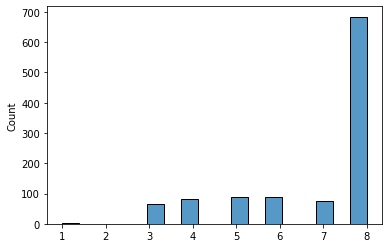

In [54]:
import seaborn as sns
sns.histplot(num_cols_iter)

In [55]:
len(num_cols_iter)

1085

In [219]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data_drop_0.pth")

In [11]:
test_veri = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth")
test_data = test_veri["data"]
test_logits = test_veri["logits"]
test_cls_indexes = test_veri["cls_indexes"]
test_embs = test_veri["embs"]
test_col_num = test_veri["col_num"]

/tmp/ipykernel_3970067/872819949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_veri = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth"

In [ ]:
len(test_data[0])

In [ ]:
len(test_data[0])

In [ ]:
test_col_num[5]

In [237]:
labels_test = []
logits_test = []
col_scores = defaultdict(list)
verifier = Verifier(norm="batch_norm").to(device)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        embs = test_embs[batch_idx][0].reshape(-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        # scores_init = verifier(embs)
        max_score = -float("inf")
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        num_cols_to_drop = min(2, len(init_permutation_i)//2)
        if len(init_permutation_i) ==1:
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
            continue
        
        for i in range(1, len(test_embs[batch_idx])):
            logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
            embs_temp = test_embs[batch_idx][i].reshape(-1).to(device)

            scores_temp = np.random.rand()
            predict_temp = logits_temp.argmax().item()
            col_scores[batch_idx].append(scores_temp)
            
            
        cols_to_drop = torch.tensor(col_scores[batch_idx]).argsort()[:num_cols_to_drop]
        x = deepcopy(init_permutation_i)
        for col_i in cols_to_drop:
            x.remove(col_i)
        new_batch_data = []
        if len(x) != len(init_permutation_i):
            drop_idx = (set(init_permutation_i)-set(x)).pop()
        else:
            drop_idx = -1
        for col_i in x:
            if col_i == 0:
                if len(new_batch_data) == 0:
                    cls_indexes_value = 0
                else:
                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
        logits_topk, embs_topk = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
        if len(init_permutation_i) > 4: 
            break

In [ ]:
x

In [ ]:
num_cols_to_drop

In [ ]:
init_permutation_i = torch.tensor(init_permutation_i)
init_permutation_i[init_permutation_i!=0][:num_cols_to_drop]

In [ ]:
torch.tensor(col_scores[batch_idx]).argsort(descending=True)[: ]

In [ ]:
len(col_scores[batch_idx])

In [ ]:
len(init_permutation_i)

In [197]:
drop_idx = (set(init_permutation_i)-set(x)).pop()

In [ ]:
drop_idx

In [ ]:
len()

In [ ]:
len(test_embs)

In [115]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data_2.pth")

In [ ]:
for i, r in enumerate(test_dataloader_iter):
    try:
        res = test_embs[i][0]
    except:
        print(i)
    

In [ ]:
res = torch.load

In [ ]:
args.task

In [ ]:
all_labels = []
for i in veri_label:
    all_labels.extend(veri_label[i])
all_labels = torch.tensor(all_labels).reshape(-1)
all_labels.sum()/len(all_labels)

In [ ]:
veri_label

In [64]:
class VerificationDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            max_list_length: int = 10,
            pos_ratio : int = 0.5, # None: only control pos_ratio to be less than 0.5
            label_padding_value: int = -1,
            data_padding_value: int = 0,
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        self.label_padding_value = label_padding_value
        self.data_padding_value = data_padding_value
        self.max_list_length = max_list_length
        self.pos_ratio = pos_ratio
        self.veri_label = {}
        self.veri_data = {}
        self.veri_cls_indexes = {}
        i = 0
        for veri_i in veri_label:
            labels_i = torch.tensor(veri_label[veri_i]).reshape(-1)
            
            if 0 not in labels_i or 1 not in labels_i:
                continue
            self.veri_data[i] = veri_data[veri_i]
            self.veri_label[i] = labels_i
            self.veri_cls_indexes[i] = veri_cls_indexes[veri_i]
            i += 1
    def sample(self, labels):
        labels = labels.tolist()  # Convert tensor to list for easier manipulation
        positive_indices = [i for i, label in enumerate(labels) if label == 1]
        negative_indices = [i for i, label in enumerate(labels) if label == 0]

        # Determine how many positives we can sample, respecting the ratio requirement
        max_num_positives = max_num_negatives = min(len(positive_indices), len(negative_indices), self.max_list_length // 2)
        
        # Randomly sample the positives and negatives
        sampled_positives = random.sample(positive_indices, max_num_positives)
        sampled_negatives = random.sample(negative_indices, max_num_negatives)

        # Combine and shuffle the indices
        sampled_indices = sampled_positives + sampled_negatives

        return sampled_indices
        # {"data": veri_data, "label": veri_label, "cls_indexes": veri_cls_indexes}
    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        labels = self.veri_label[idx]
        sampled_indices = self.sample(labels)
        sampled_labels = torch.tensor([labels[i] for i in sampled_indices]).reshape(-1)
        sampled_data = [self.veri_data[idx][i].reshape(-1) for i in sampled_indices]
        sampled_cls_indexes = torch.tensor([self.veri_cls_indexes[idx][i] for i in sampled_indices], dtype=torch.long)
        if len(sampled_indices) < self.max_list_length:
            sampled_labels = torch.cat([sampled_labels, torch.ones(self.max_list_length - len(sampled_labels))*self.label_padding_value])
            sampled_data.extend([torch.tensor([self.data_padding_value]) for _ in range(self.max_list_length - len(sampled_data))])
            sampled_cls_indexes = torch.cat([sampled_cls_indexes, torch.zeros(self.max_list_length - len(sampled_cls_indexes))])
        return {
            "data": sampled_data,
            "label": sampled_labels,
            "cls_indexes": sampled_cls_indexes, 
        }

In [64]:
class VerificationBinaryDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            pos_ratio = None, # clone the negative samples
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        veri_embs = data_raw["embs"]
        veri_logits = data_raw["logits"]
        self.neg_expand = int(1/pos_ratio)-1 if pos_ratio is not None else 1
        self.veri_label = {}
        self.veri_data = {}
        self.veri_embs = {}
        self.veri_cls_indexes = {}
        self.veri_logits = {}
        i = 0
        for veri_i in veri_label:
            for veri_j in range(len(veri_label[veri_i])):
                if veri_label[veri_i][veri_j] == 1:
                    labels_i = torch.tensor([1]).reshape(-1)
                    self.veri_data[i] = veri_data[veri_i][veri_j]
                    self.veri_label[i] = labels_i
                    self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                    self.veri_embs[i] = veri_embs[veri_i][veri_j]
                    self.veri_logits[i] = veri_logits[veri_i][veri_j]
                    i += 1
                else:
                    for _ in range(self.neg_expand):
                        labels_i = torch.tensor([0]).reshape(-1)
                        self.veri_data[i] = veri_data[veri_i][veri_j]
                        self.veri_label[i] = labels_i
                        self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                        self.veri_embs[i] = veri_embs[veri_i][veri_j]
                        self.veri_logits[i] = veri_logits[veri_i][veri_j]
                        i += 1

    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        return {
            # "data": self.veri_data[idx].reshape(-1),
            "embs": self.veri_embs[idx].reshape(-1),
            "label": self.veri_label[idx],
            "logits": self.veri_logits[idx],
            # "cls_indexes": self.veri_cls_indexes[idx], 
        }

In [ ]:
print(len(veri_dataset), len(veri_dataset.veri_data), len(veri_dataset.veri_label), len(veri_dataset.veri_cls_indexes))

In [ ]:
verit_binary_dataset = VerificationBinaryDataset()

In [ ]:
len(verit_binary_dataset)

In [11]:
data = torch.nn.utils.rnn.pad_sequence(
            [verit_binary_dataset[i]["data"] for i in range(10)], padding_value=0)

In [ ]:
verit_binary_dataset[0]["embs"].shape

In [53]:
verit_labels = []
for i in range(len(verit_binary_dataset)):
    verit_labels.append(verit_binary_dataset[i]["label"].item())

In [ ]:
torch.tensor(verit_labels).sum()/len(verit_labels)

In [ ]:
len(veri_dataset)

In [ ]:
veri_dataset = VerificationDataset()

In [ ]:
len(veri_dataset)

In [21]:
res = veri_dataset[0]

In [ ]:
len(res["data"])

In [ ]:
res["data"][0].shape

In [ ]:
res["label"].shape

In [35]:
data_test = []
for i in range(len(veri_dataset)):
    data_test.extend(veri_dataset[i]["data"])

In [ ]:
len(data_test)

In [69]:
def veri_collate_fn(pad_token_id, binary=False):
    '''padder for input batch'''
    
    def padder(samples):    
        data = []
        for sample in samples:
            data.extend(sample["data"])
        data =torch.nn.utils.rnn.pad_sequence(
            data, padding_value=pad_token_id)

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"data": data, "label": label}
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                for value in sample["cls_indexes"]:
                    cls_indexes.append(torch.tensor([i, value]))
                    i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        return batch
    
    def padder_binary(samples):   

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"label": label}
        if  "data" in samples[0]:
            data = torch.nn.utils.rnn.pad_sequence(
                [sample["data"] for sample in samples], padding_value=pad_token_id)
            batch["data"] = data
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                value =  sample["cls_indexes"]
                cls_indexes.append(torch.tensor([i, value]))
                i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        if "logits" in samples[0]:
            logits = torch.stack([sample["logits"] for sample in samples], dim=0)
            batch["logits"] = logits
        return batch
    if binary:
        return padder_binary
    else:
        return padder

In [ ]:
veri_padder = veri_collate_fn(0)
veri_dataloader = data.DataLoader(
    veri_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_padder
)
for batch in veri_dataloader:
    break

In [70]:
veri_binary_padder = veri_collate_fn(0, binary=True)
veri_binary_dataloader = data.DataLoader(
    verit_binary_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_binary_padder
)
for batch_idx, batch in enumerate(veri_binary_dataloader):
    break

In [ ]:
batch["embs"].shape

In [ ]:
batch["logits"].shape

In [ ]:
scores.shape

In [ ]:
batch["label"].to(device).squeeze().shape

In [38]:
model.eval()
model = model.to(device)
verifier.train()
verifier = verifier.to(device)
pos_ratio = 0.1
pos_weight = torch.tensor([(1-pos_ratio)/pos_ratio]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for batch_idx, batch in enumerate(veri_binary_dataloader ):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs).squeeze()
    loss = loss_fn(scores, batch["label"].to(device).squeeze().float())
    break

In [ ]:
 batch["label"].to(device).shape

In [ ]:
scores.shape

In [ ]:
batch["data"].shape

In [ ]:
for 

In [ ]:
args.batch_size

In [ ]:
batch["data"].shape

In [ ]:
batch["label"].shape

In [ ]:
batch["cls_indexes"].shape

In [8]:
verifier = Verifier(norm="batch_norm", num_layers=None).to(device)

In [9]:
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.1-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_macro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.1-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-search@0-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")
veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")

/tmp/ipykernel_3970067/89480059.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/be

In [10]:
verifier.load_state_dict(veri_state_dict)

<All keys matched successfully>

In [ ]:
verifier.eval()

In [ ]:
optimizer = AdamW(verifier.parameters(), lr=args.lr, eps=1e-8)

In [16]:
model.eval()
model.to(device)
verifier.train()
tr_loss = 0.0
for batch_idx, batch in enumerate(veri_dataloader):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs)
    loss = listMLE(scores.reshape(args.batch_size, -1), batch["label"].to(device).reshape(args.batch_size, -1))

    accelerator.backward(loss)
    # loss.backward()
    tr_loss += loss.cpu().detach().item()
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
scores.shape

In [11]:
import torch


def listMLE(y_pred, y_true, eps=1e-10, padded_value_indicator=-1):
    """
    ListMLE loss introduced in "Listwise Approach to Learning to Rank - Theory and Algorithm".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    return torch.mean(torch.sum(observation_loss, dim=1))

In [21]:
bs = 3


In [ ]:
loss

In [19]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    scores_init = verifier(embs)
    max_score = -float("inf")
    if 1 in target_col_mask:
        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                if 0 not in x:
                    cls_indexes_value = 0
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                scores_temp = verifier(embs).item()
                predict_temp = logits_temp.argmax().item()
                    # if len(x) == 1 and 0 in x:
                    #     predict_target = predict_temp
                    #     msp_target = msp_temp
                    # # print(x, msp_temp, predict_temp)
                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                    #     debias_classes.append(predict_temp)
                    #     continue
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")

In [24]:
init_correctness = torch.tensor(init_correctness)
final_correctness = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)

In [ ]:
(init_correctness | final_correctness).sum()

In [ ]:
import seaborn as sns
sns.histplot(init_scores)

In [ ]:
sns.histplot(F.sigmoid(init_scores))

In [ ]:
F.sigmoid(init_scores)[init_correctness].mean()

In [ ]:
F.sigmoid(init_scores)[~init_correctness].mean()

In [ ]:
F.sigmoid(final_scores)[init_correctness].mean()

In [ ]:
F.sigmoid(final_scores)[~init_correctness].mean()

In [ ]:
sns.histplot(final_scores)

In [ ]:
sns.histplot(F.sigmoid(final_scores))

In [ ]:
ts_macro_f1

In [ ]:
correct_init_mask = init_correctness
correct_msp_mask = final_correctness
for threshold in [ 0.9, 0.99, 0.999]:
    uncertain_init_mask = F.sigmoid(init_scores) < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")
    # print((condition_mask&correct_permutation_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_mask).sum().item(), 
    #      (~condition_mask).sum().item(), 
    #     (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    # print("Permutation Confident")
    # print((condition_mask&correct_permutation_confident_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_confident_mask).sum().item(),
    #         (~condition_mask).sum().item(), 
    #         (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [12]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(len(init_permutation_i))
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                    final_step = len(init_permutation_i) - r
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        final_steps.append(final_step)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

final_correctness = torch.tensor(final_correctness)
init_correctness = torch.tensor(init_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
final_steps = torch.tensor(final_steps)
total_steps = torch.tensor(total_steps)
final_scores = F.sigmoid(torch.tensor(final_scores))
init_scores = F.sigmoid(torch.tensor(init_scores))

ts_micro_f1=0.5631, ts_macro_f1=0.3018


/tmp/ipykernel_3970067/3186715187.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_scores = F.sigmoid(torch.tensor(final_scores))
/tmp/ipykernel_3970067/3186715187.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_scores = F.sigmoid(torch.tensor(init_scores))


In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(len(init_permutation_i))
        if len(init_permutation_i) <= 1:
            continue
        for r in range(len(init_permutation_i), min(3, len(init_permutation_i)//2-1), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                    final_step = len(init_permutation_i) - r
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        final_steps.append(final_step)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

final_correctness = torch.tensor(final_correctness)
init_correctness = torch.tensor(init_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
final_steps = torch.tensor(final_steps)
total_steps = torch.tensor(total_steps)
final_scores = F.sigmoid(torch.tensor(final_scores))
init_scores = F.sigmoid(torch.tensor(init_scores))

In [291]:
to_check_idx = []
for i in (torch.tensor(final_correctness) == False).nonzero().reshape(-1).tolist():
    if len(correct_scores[i])>0:
        to_check_idx.append(i)

In [ ]:
to_check_idx[:10]

In [304]:
to_check_idx_init = []
for i in (torch.tensor(final_correctness) == False).nonzero().reshape(-1).tolist():
    if init_correctness[i] == True:
        to_check_idx_init.append(i)

In [ ]:
to_check_idx_init[:5]

In [ ]:
[34, 52] in to_check_idx_init[:5]

In [ ]:
set([34, 52]).issubset(set(to_check_idx_init[:5]))

In [ ]:
len(to_check_idx_init)

In [ ]:
target_idx = 53
print(final_scores[target_idx], final_correctness[target_idx], init_correctness[target_idx], init_scores[target_idx], num_cols[target_idx], 
      final_steps[target_idx], total_steps[target_idx], labels_test[target_idx], preds_test[target_idx])

In [ ]:
F.sigmoid(torch.tensor(correct_scores[target_idx]))

In [ ]:
np.array(num_cols)

In [ ]:
np.array(final_steps)

In [ ]:
np.array(total_steps)

In [ ]:
sns.histplot(np.array(final_steps)/np.array(total_steps))

In [ ]:
print(len(correct_scores), len(test_dataloader_iter))

In [ ]:
sns.histplot(torch.tensor(final_steps)[final_correctness==True]/torch.tensor(total_steps)[final_correctness==True])

In [ ]:
sns.histplot(torch.tensor(num_cols)[final_scores>0.999])

In [374]:
num_cols = torch.tensor(num_cols)

In [ ]:
for num_col in num_cols.unique():
    print(num_col, ((final_scores>0.999)&(num_cols==num_col)).sum()/(num_cols==num_col).sum())

In [ ]:
sns.histplot(torch.tensor(num_cols))

In [ ]:
(torch.tensor(num_cols)<8).sum()/len(num_cols)

In [ ]:
sns.histplot(torch.tensor(final_steps)[final_scores>0.999]/torch.tensor(total_steps)[final_scores>0.999])

In [ ]:
sns.histplot(final_scores)

In [ ]:
sns.histplot(F.sigmoid(final_scores))

In [ ]:
ts_f1_full - full_f1_init

In [ ]:
correct_init_mask = torch.tensor(init_correctness)
correct_msp_mask = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
for threshold in [0.9, 0.99, 0.999, 0.9999, 0.99999]:
    uncertain_init_mask = init_scores < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")

In [ ]:
print((final_scores>0.999).sum(), (final_scores>0.999).sum()/len(final_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for threshold in [0.9, 0.99, 0.999]:
    print(f"*********************Threshold: {threshold}****************************")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > threshold:
                        enough = True
                if enough:
                    break  
                
                
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))

In [37]:
threshold = 0.999999

In [ ]:
print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [ ]:
max_length

In [ ]:
src = None
test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=16,
                            adaptive_max_length=False,)
padder = collate_fn(tokenizer.pad_token_id)
# test_dataloader_iter_extra = DataLoader(test_dataset_iter_extra,
#                                 batch_size=1,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)

In [ ]:
test_dataset_iter_extra

In [362]:
num_cols_extra = []
for i in range(len(test_dataset_iter_extra)):
    init_permutation_i = get_permutation(test_dataset_iter_extra[i]["target_col_mask"].T)
    num_cols_extra.append(len(init_permutation_i))
    

In [376]:
init_permutation_i, init_permutation_i_extra = init_permutation_i[:8], init_permutation_i[8:]

In [ ]:
sns.histplot(num_cols_extra)

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [16]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            if 0 not in init_permutation_i:
                col_to_exclude = init_permutation_i[-1]
                init_permutation_i = init_permutation_i[:-1] + [0]
                init_permutation_i_extra.remove(0)
                init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
                assert 0 in init_permutation_i and 0 not in init_permutation_i_extra
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > threshold:
                        enough = True
                if enough:
                    break  
            if not enough and len(init_permutation_i_extra)>0:
                for new_col_idx in init_permutation_i_extra:
                    init_permutation_i_new = init_permutation_i + [new_col_idx]
                    for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                        for x in itertools.combinations(init_permutation_i_new, r):
                            if 0 not in x or new_col_idx not in x:
                                continue
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                            if logits_temp.argmax().item() == batch["label"].item():
                                correct_scores[batch_idx].append(scores_temp)
                                correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    #         if F.sigmoid(torch.tensor(max_score)).item() > threshold:
                    #             enough = True
                    #     if enough:
                    #         break
                    # if enough:
                    #     break
                    
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>threshold).sum(), len(final_scores), (final_scores>threshold).sum()/len(final_scores))

In [ ]:
ts_micro_f1=0.5567, ts_macro_f1=0.2983

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [32, 64, 128]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            if 0 not in init_permutation_i:
                col_to_exclude = init_permutation_i[-1]
                init_permutation_i = init_permutation_i[:-1] + [0]
                init_permutation_i_extra.remove(0)
                init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
                assert 0 in init_permutation_i and 0 not in init_permutation_i_extra
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                        enough = True
                if enough:
                    break  
            if not enough and len(init_permutation_i_extra)>0:
                for new_col_idx in init_permutation_i_extra:
                    init_permutation_i_new = init_permutation_i + [new_col_idx]
                    for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                        for x in itertools.combinations(init_permutation_i_new, r):
                            if 0 not in x or new_col_idx not in x:
                                continue
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                            if logits_temp.argmax().item() == batch["label"].item():
                                correct_scores[batch_idx].append(scores_temp)
                                correct_steps[batch_idx].append(len(init_permutation_i) - r)
                            if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                                enough = True
                        if enough:
                            break
                    if enough:
                        break
                    
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [16]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                        enough = True
                if enough:
                    break  
                
            if not enough and len(init_permutation_i_extra)>0:
                for z in range(1, len(init_permutation_i_extra)+1):
                    for new_col_idx in itertools.combinations(init_permutation_i_extra, z):
                        init_permutation_i_new = init_permutation_i + list(new_col_idx)
                        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1):
                            for x in itertools.combinations(init_permutation_i_new, r):
                                if not set(list(new_col_idx)+[0]).issubset(init_permutation_i_new):
                                    continue
                                new_batch_data = []
                                for col_i in x:
                                    if col_i == 0:
                                        if len(new_batch_data) == 0:
                                            cls_indexes_value = 0
                                        else:
                                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                                scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                                predict_temp = logits_temp.argmax().item()
                                
                                if scores_temp > max_score:
                                    max_score = scores_temp
                                    logits = logits_temp.clone()
                                    final_step = len(init_permutation_i) - r
                                if logits_temp.argmax().item() == batch["label"].item():
                                    correct_scores[batch_idx].append(scores_temp)
                                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                                if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                                    enough = True
                            if enough:
                                break
                        if enough:
                            break
                        
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [407]:
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            if len(init_permutation_i_extra) == 2:
                break

In [ ]:
init_permutation_i

In [411]:
if 0 not in init_permutation_i:
    col_to_exclude = init_permutation_i[-1]
    init_permutation_i = init_permutation_i[:-1] + [0]
    init_permutation_i_extra.remove(0)
    init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
    assert 0 in init_permutation_i and 0 not in init_permutation_i_extra

In [ ]:
init_permutation_i

In [ ]:
init_permutation_i_extra

In [ ]:
                for z in range(1, len(init_permutation_i_extra)+1):
                    for new_col_idx in itertools.combinations(init_permutation_i_extra, z):
                        init_permutation_i_new = init_permutation_i + list(new_col_idx)
                        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1):
                            for x in itertools.combinations(init_permutation_i_new, r):
                                if not set(list(new_col_idx)+[0]).issubset(init_permutation_i_new):
                                    continue

In [ ]:
init_permutation_i_extra

In [390]:
num_cols = []
for batch_idx, batch in enumerate(test_dataset_iter_extra):
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        num_cols.append(len(init_permutation_i))

In [ ]:
sns.histplot(num_cols)

# table search STARMIE

In [22]:
column_list_1 = [
    "Name: Philip Duffy; Jeremy Oppenheim; Mark Sedwill;",
    "Mode of Travel: Air; Taxi; Air;",
    "Purpose: Regional Meeting; Exchange Visit; Evening Meal;",
    "Destination: London; Ottawa; Bristol;",
    "Day: 10; 30; 02;",
    "Month: April; July; September;",
    "Year: 2019; 2019; 2019;",
    "Expense: 189.06; 8.08; 50.00;"
]


In [33]:

cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_1 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [58]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_1_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [63]:
column_list_2 = [
    "Name: Clark; Gyimah; Harrington;",
    "Date: 23/07; 03/09; 05/08;",
    "Destination: France; Belgium; China;",
    "Purpose: Discuss EU; Build Relations; Discuss Productivity;",
]
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_2 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [ ]:
token_ids = token_ids.reshape(1, -1)
attention_mask = token_ids != 0
res = model.bert(token_ids, attention_mask=attention_mask, return_dict=True, output_attentions=True)

In [ ]:
len(res['attentions'])

In [ ]:
res['attentions'][0]

In [ ]:
res['attentions'][0].squeeze().mean(0).shape

In [ ]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask]

In [ ]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = []
for i in range(len(res['attentions'])):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention.append(attn_i)
    print(attn_i)
acc_attention = torch.stack(acc_attention, dim=0)

In [ ]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = torch.ones_like(res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0))
for i in range(len(res['attentions'])-1, -1, -1):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention = acc_attention * attn_i
    print(acc_attention)

In [ ]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].fill_diagonal_(0).mean(0)

In [59]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_2_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [38]:
column_list_3 = [
    'Bird Name: Pine Siskin; American Robin; Northern Flicker;',
    'Scientific Name: Carduelis Pinus; Turdus migratorius; Colaptes auratus;',
    'Date: 2019; 2019; 2019;',
    'Location: Ottawa; Ottawa; London;'
]

cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_3 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [60]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_3_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [ ]:
embs_1.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy())

In [ ]:
print(cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0).sum()

In [ ]:
print(cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0).sum()

In [ ]:
print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [32]:
test_dataset = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth")
test_embs = test_dataset['embs']
test_class = test_dataset['class']
test_label = test_dataset['label']

/tmp/ipykernel_4026465/1559134942.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.

In [56]:
test_dataset.keys()

dict_keys(['data', 'logits', 'cls_indexes', 'embs', 'target_embs', 'col_num', 'label', 'class'])

[4, 3, 3, 3]

In [40]:
len(test_embs_pos)

12501

In [41]:
len(test_embs_neg)

11892

In [37]:
test_embs_pos = []
test_embs_neg = []
for batch_idx in range(len(test_embs)):
    for i in range(len(test_embs[batch_idx])):
        if test_labels[batch_idx][i].item() == 1:
            test_embs_pos.append(test_embs[batch_idx][i])
        else:
            test_embs_neg.append(test_embs[batch_idx][i])
test_embs_pos = torch.stack(test_embs_pos, dim=0)
test_embs_neg = torch.stack(test_embs_neg, dim=0)
    

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Pairwise cosine similarity
test_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), test_embs_neg.numpy())

In [38]:
test_embs_pos.shape

torch.Size([12501, 768])

In [17]:
test_similarity_matrix.max(1).mean()

0.94780064

In [18]:
test_similarity_matrix.mean()

0.111379325

In [30]:
tpvp_similarity_matrix.shape

(12501, 84031)

In [19]:
veri_results = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_5.pth")
veri_label = veri_results['label']
veri_embs = veri_results['embs']

/tmp/ipykernel_4026465/557746203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  veri_results = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_5

In [21]:
veri_embs_pos = []
veri_embs_neg = []
for batch_idx in range(len(veri_embs)):
    for i in range(len(veri_embs[batch_idx])):
        if veri_label[batch_idx][i].item() == 1:
            veri_embs_pos.append(veri_embs[batch_idx][i])
        else:
            veri_embs_neg.append(veri_embs[batch_idx][i])
veri_embs_pos = torch.stack(veri_embs_pos, dim=0)
veri_embs_neg = torch.stack(veri_embs_neg, dim=0)

In [22]:
tpvp_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), veri_embs_pos.numpy())
tpvn_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), veri_embs_neg.numpy())

In [28]:
tnvp_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_pos.numpy())
tnvn_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_neg.numpy())

In [24]:
print(tpvp_similarity_matrix.max(1).mean(), tpvp_similarity_matrix.mean())

0.9657009 0.17322846


In [27]:
print(tpvn_similarity_matrix.max(1).mean(), tpvn_similarity_matrix.mean())

0.9559124 0.14575109


In [29]:
print(tnvp_similarity_matrix.max(1).mean(), tnvp_similarity_matrix.mean())
print(tnvn_similarity_matrix.max(1).mean(), tnvn_similarity_matrix.mean())

0.8502803 0.08830399
0.8699045 0.081692524


In [58]:
veri_results = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_4.pth")
veri_label = veri_results['label']
veri_embs = veri_results['embs']

/tmp/ipykernel_4026465/1451746444.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  veri_results = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_

In [59]:
veri_embs_pos = []
veri_embs_neg = []
for batch_idx in range(len(veri_embs)):
    for i in range(len(veri_embs[batch_idx])):
        if veri_label[batch_idx][i].item() == 1:
            veri_embs_pos.append(veri_embs[batch_idx][i])
        else:
            veri_embs_neg.append(veri_embs[batch_idx][i])
veri_embs_pos = torch.stack(veri_embs_pos, dim=0)
veri_embs_neg = torch.stack(veri_embs_neg, dim=0)

In [65]:
test_embs_pos

tensor([[ 0.8687,  0.9182, -0.8263,  ...,  0.7522,  0.8715,  0.4586],
        [ 0.8572,  0.9041, -0.7880,  ...,  0.8075,  0.8726,  0.5800],
        [ 0.8715,  0.9171, -0.8301,  ...,  0.7428,  0.8663,  0.4430],
        ...,
        [ 0.7532,  0.9257, -0.8568,  ...,  0.7762,  0.8702,  0.7592],
        [ 0.7319,  0.9229, -0.8659,  ...,  0.7707,  0.8672,  0.7369],
        [ 0.6951,  0.9259, -0.8172,  ...,  0.8195,  0.8404,  0.7706]])

In [60]:
tpvp_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), veri_embs_pos.numpy())
tpvn_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), veri_embs_neg.numpy())

In [61]:
tnvp_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_pos.numpy())
tnvn_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_neg.numpy())

In [62]:
print(tpvp_similarity_matrix.max(1).mean(), tpvp_similarity_matrix.mean())
print(tpvn_similarity_matrix.max(1).mean(), tpvn_similarity_matrix.mean())

0.9656329 0.1726674
0.9511409 0.1378151


In [63]:
tnvp_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_pos.numpy())
tnvn_similarity_matrix = cosine_similarity(test_embs_neg.numpy(), veri_embs_neg.numpy())

In [64]:
print(tnvp_similarity_matrix.max(1).mean(), tnvp_similarity_matrix.mean())
print(tnvn_similarity_matrix.max(1).mean(), tnvn_similarity_matrix.mean())

0.85004056 0.08802708
0.86059237 0.07896456


In [68]:
from sklearn.metrics import silhouette_score
print(silhouette_score(torch.cat([test_embs_pos, veri_embs_pos], dim=0).numpy(), torch.cat([torch.zeros(test_embs_pos.shape[0]), torch.ones(veri_embs_pos.shape[0])]).numpy(), metric="cosine"))

-0.036336727


In [69]:
from sklearn.metrics import silhouette_score
print(silhouette_score(torch.cat([test_embs_pos, veri_embs_neg], dim=0).numpy(), torch.cat([torch.zeros(test_embs_pos.shape[0]), torch.ones(veri_embs_neg.shape[0])]).numpy(), metric="cosine"))

-0.015460037


In [70]:
from sklearn.metrics import silhouette_score
print(silhouette_score(torch.cat([test_embs_neg, veri_embs_neg], dim=0).numpy(), torch.cat([torch.zeros(test_embs_neg.shape[0]), torch.ones(veri_embs_neg.shape[0])]).numpy(), metric="cosine"))

0.014984836


In [71]:
from sklearn.metrics import silhouette_score
print(silhouette_score(torch.cat([test_embs_neg, veri_embs_pos], dim=0).numpy(), torch.cat([torch.zeros(test_embs_neg.shape[0]), torch.ones(veri_embs_pos.shape[0])]).numpy(), metric="cosine"))

0.045245163
